In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

## Loading Data Set

In [4]:
import os
import kagglehub
import shutil

#if the file doesn't exist, we need re-download it

path = kagglehub.dataset_download("sakhawat18/asteroid-dataset") #download file
actual_csv_path = os.path.join(path, 'dataset.csv') #append the dataset file to the path dir

In [54]:
df = pd.read_csv(actual_csv_path, low_memory=False)
df.columns = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]

##Pre-Processing (Removing Non-Useful Information; refer to [MS3](https://github.com/balexdalex42/CSE151A-Group-Project-Gordon-Yang-Nafi-Mahbub-Alex-Tatoian-/tree/Milestone3))
We classify these columns as non-useful because attributes such as the name or the uncertainty in one of the measured values will not contribute to how the data acts.

In [9]:
df_new = df.copy()
cols_to_drop = ['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'diameter',
                'albedo', 'diameter_sigma', 'orbit_id', 'epoch_mjd', 'epoch_cal',
                'equinox', 'tp_cal', 'per_y', 'moid_ld']
sigma_cols = ['sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w',
              'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per']
df_new.drop(columns=cols_to_drop, inplace=True)
df_new.drop(columns=sigma_cols, inplace=True)

In [10]:
final_df = df_new.dropna()
print(final_df.shape)

(932335, 18)


## Starting Unsupervised Learning

### Dropping Output Feature; Not Used for Unsupervised Learning (Will Be Used Later For Training)



In [11]:
X = final_df.drop(columns=['pha'])
y = (final_df['pha'] == 'Y').astype(int)

### One-Hot Encoding for the Categorical Variables in the Remaining Data

In [12]:
# Encode the columns using one-hot
X = pd.get_dummies(X, drop_first=True)

## Let us investigate the PCA of This Data to See if We Can Arrive at Some Understandings/Conclusions

In [13]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [14]:
# Try a 2D PCA and visualize it
pca2d = PCA(n_components=2)
X_pca2d = pca2d.fit_transform(X_sc)

In [15]:
X_pca2d.shape

(932335, 2)

In [16]:
import seaborn as sns

In [55]:
# creating PCA dataframe so we can graph the data
pca_vis_df = pd.DataFrame({
    'PCA1' : X_pca2d[:,0],
    'PCA2' : X_pca2d[:,1],
    'pha' : y
})

Text(0.5, 1.0, 'Asteroid Dataset Principle Component Analysis (dims=2)')

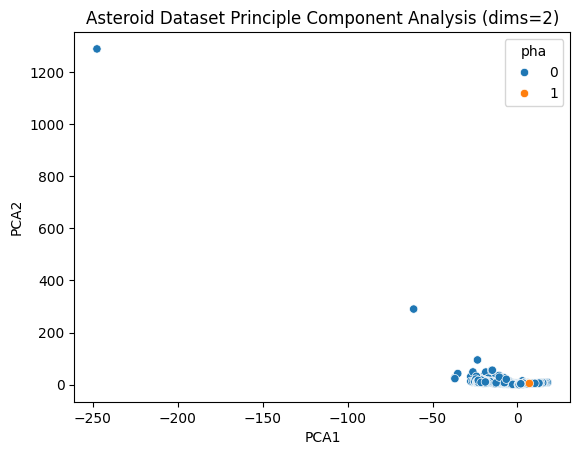

In [18]:
sns.scatterplot(data=pca_vis_df, x='PCA1', y='PCA2', hue='pha')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Asteroid Dataset Principle Component Analysis (dims=2)')

A crucial thing to notice is that most of the data is very close to the PCA1 axis, meaning we can get a small hint that maybe PCA1 accounts for most of the variance in the data! We will actually see that our first PC ends up accounting for upwards of 99% of the data's variance! 😮

### Let's move on to PCA with 5 components...

In [56]:
pca5 = PCA(n_components=5)
X_pca5 = pca5.fit_transform(X)

In [24]:
pca5.explained_variance_ratio_

array([9.99999468e-01, 4.65266356e-07, 6.05885756e-08, 2.22223652e-09,
       1.96657447e-09])

**WOW!** Looking at the explained variance ratios, we see that PC1 alone accounts for more than 99.9999% of the variance in the dataset. This confirms that the strong pattern we observed in the 2-component PCA plot was not incidental, but in fact highly telling — nearly all of the data's structure is driven by a single principal component. 🤔

In [25]:
pca5.singular_values_

array([2.26056419e+09, 1.54194110e+06, 5.56432298e+05, 1.06564389e+05,
       1.00247178e+05])

In [58]:
pca5.feature_names_in_

array(['h', 'epoch', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'tp',
       'per', 'moid', 'rms', 'neo_Y', 'class_APO', 'class_AST',
       'class_ATE', 'class_CEN', 'class_IEO', 'class_IMB', 'class_MBA',
       'class_MCA', 'class_OMB', 'class_TJN', 'class_TNO'], dtype=object)

## Let's Try Clustering the Data to See if Can Notice Anything More

### Trying K-Means Using Our 2-Component PCA

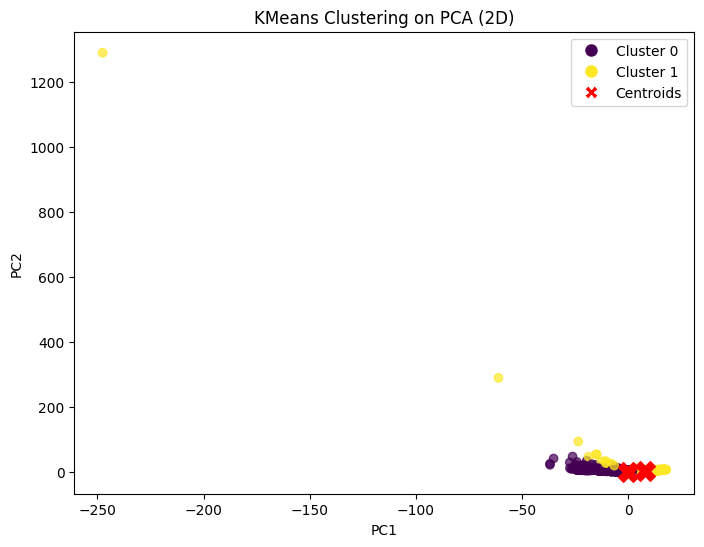

In [66]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

# Remember X_pca2d is our 2-Comp PCA Data
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_pca2d)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca2d[:,0], X_pca2d[:,1], c=labels, cmap='viridis', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            c='red', marker='X', s=200)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clustering on PCA (2D)")

# Create a legend mapping colors to cluster numbers
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                          markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10)
                   for i in range(k)]
legend_elements.append(Line2D([0], [0], marker='X', color='w', label='Centroids',
                              markerfacecolor='red', markersize=10))
plt.legend(handles=legend_elements)
plt.show()

We would like to show that in this case, K-Means does an absolutely **terrible** job at clustering. This is because this data itself doesn't look appropriate for clustering around 2 centroids. Originally, the idea of why we chose $k=2$ was purely because we knew that we had only 2 classes. 😞

## Model Training (Using KNN)

### Splitting the Data

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"x_train shape: {X_train.shape}")
print(f"x_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (745868, 27)
x_test shape: (186467, 27)
y_train shape: (745868,)
y_test shape: (186467,)


### Getting the SVD of our Training Matrix

Note: We also need the test matrix `X_sc_test` for our classification report!

In [60]:
#training
scaler = StandardScaler()
X_sc_train = scaler.fit_transform(X_train)
U_train, S_train, V_train_t = np.linalg.svd(X_sc_train, full_matrices=False)
#Need centered testing matrix, note we use training mean though; NO DATA LEAKAGE ALLOWED
X_sc_test = scaler.transform(X_test)


#### Some Thresholds That Users Can Edit to Play Around With the Data... 😸

In [62]:
#DEFINING CERTAIN CONSTANTS
max_num_neighbors = 15
#We know that we don't need to iterate to higher dim, since the dimensions would exp 95% of the var
variance_threshold = 0.05
#How many dimension do we want to go up to (max 27, but that will be too slow)
max_k = 8 #we default to 8

### Performing Cross Validation to Determine the Best Pair of $k$ (dimensions in $X$ that we reduce to) and `num_neighbors` (from the KNN)

In [63]:
import random #for the showing of the accuracy of the model
#Now performing the Cross-Validation to get best k-value and number of neighbors
from sklearn.neighbors import KNeighborsClassifier

accuracy_scores = [] # just to show
best_macro_f1 = 0
best_k = 0
best_num_neighbors = 0

for k in range(1, max_k):
  U_k, S_k, Vt_k = U_train[:, :k], S_train[:k], V_train_t[:k, :]
  X_train_k = U_k @ np.diag(S_k) # could've used formula Xc_train @ Vt_k.T
  X_test_k = X_sc_test @ Vt_k.T
  for num_neighbors in range(1, max_num_neighbors + 1):
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    knn.fit(X_train_k, y_train)
    y_pred = knn.predict(X_test_k)
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy_scores.append(report['accuracy'])
    if report['macro avg']['f1-score'] > best_macro_f1:
      best_macro_f1 = report['macro avg']['f1-score']
      best_k = k
      best_num_neighbors = num_neighbors
print(f"best_k: {best_k}")
print(f"best_num_neighbors: {best_num_neighbors}")
print(f"best_macro_f1: {best_macro_f1}")
print(f"Random 10 accuracy scores: {random.sample(accuracy_scores, 10)}")

best_k: 6
best_num_neighbors: 3
best_macro_f1: 0.6927143065865731
Random 10 accuracy scores: [0.9976349702628348, 0.9978226710356256, 0.9979942831707487, 0.9979352914993002, 0.9980532748421973, 0.9980640006006425, 0.9979674687746357, 0.9977261392096188, 0.9980479119629747, 0.9976027929874991]


We can see that our *absolute* best $k$, `num-neighbors` pair, our model will is correctly predicting about 70% of positives for each class (Hazardous and Non-Hazardous). We selected a random 10 accuracy scores to show how incredibly inflated accuracy can be, as well as how sly it can be about the performance of the model. While our model does a *decent* job at classification between the two classes, the accuracy would imply that our model is almost absolutely perfect which is absolutely NOT the case. **In context of this data, only about 0.2% of the asteroids were classified as Hazardous while the rest where not, that means that as long as our model is good at predicting non-hazardous asteroids (which is very easy), then it will automatically be around 99% accurate!**  
We lay this out as a careful reminder of how tricky statistics and labels can be...   

Note: We actually tried to use the variance threshold to pre-determine what the max value of $k$ we would iterate to, but PC1 is so incredibly influential, that when using cumulative variance ratio:
$$\sum_{i=1}^{k}{\text{Explanatory Variance Ratio}}_i,$$
no matter the choice of $k$, we would always be greater than the threshold (because **PC1 contributed to more than 99.9999% of the data's variance!**). Because of this we had to scratch the calculation and try to show higher values of $k$.